In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

In [2]:
import stan_utility

In [3]:
import stan

# Bayesian Inference

### fake data

In [47]:
from faker import Faker # library for generating random num

faker = Faker()
Faker.seed(1000)

# Generate fake data
data_simu = {
    'Pregnancies': [faker.random_int(min=0, max=17) for _ in range(3000)],
    'Glucose': [faker.random_int(min=0, max=200) for _ in range(3000)],
    'BloodPressure': [faker.random_int(min=0, max=100) for _ in range(3000)],
    'SkinTickness': [faker.random_int(min=0, max=100) for _ in range(3000)],
    'Insulin': [faker.random_int() for _ in range(3000)],
    'BMI': [faker.random.uniform(a=0, b=67) for _ in range(3000)],
    'DiabetesPedigreeFunction': [faker.random.uniform(a=0, b=3) for _ in range(3000)],
    'Age': [faker.random_int(min=1, max=100) for _ in range(3000)],
    'Outcome': [faker.random_int(min=0, max=1) for _ in range(3000)]
}


# Create a DataFrame
df_simu = pd.DataFrame(data_simu)

# Display the DataFrame
df_simu.head()

,Pregnancies,Glucose,BloodPressure,SkinTickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,13,59,24,99,6861,40.375093,1.122980,90,1
1,3,198,62,54,7416,60.019936,1.164683,84,1
2,12,89,42,80,7606,29.901838,0.776493,50,0
3,11,169,66,73,9796,18.782294,2.959806,82,1
4,2,24,60,76,247,13.799934,1.003071,90,0


In [7]:
df_simu.describe()

,Pregnancies,Glucose,BloodPressure,SkinTickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,8.546000,101.152667,50.608333,49.796667,4960.285333,33.350612,1.487909,50.666667,0.497333
std,5.159078,58.629718,29.006288,29.239134,2856.292654,19.085782,0.867345,29.201538,0.500076
min,0.000000,0.000000,0.000000,0.000000,2.000000,0.013702,0.000393,1.000000,0.000000
25%,4.000000,51.000000,26.000000,25.000000,2485.250000,16.784712,0.733832,25.000000,0.000000
50%,8.000000,102.000000,51.000000,50.000000,4942.500000,33.096036,1.477582,50.000000,0.000000
75%,13.000000,153.000000,75.000000,75.000000,7436.250000,49.275035,2.233451,77.000000,1.000000
max,17.000000,200.000000,100.000000,100.000000,9994.000000,66.993839,2.999799,100.000000,1.000000


## 1. Bayseian modeling

In [15]:
import nest_asyncio #this library is important to use pystan

nest_asyncio.apply()

In [16]:
import pandas as pd
import csv

In [17]:
import scipy.stats as stats

In [18]:
## import data

df = pd.read_csv('./db/diabetes.csv')

### purpose of analysis
The goal of this analysis is to understand how liklihood of diabetes happened with the age of pregnancies.\
In order to understand it, we will use a bayesian linear regression model.


#### 1. EDA
In order to set initial assumption as prior distribution, we conducted EDA to plot distribution of age and diabetes (DiabetesPedigreeFunction).

source: https://sakurachaojun.github.io/PSYO3505/data/EDA.html

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [ ]:
observation = {
    "N": len(df), 
   "glucose": df.loc[:, "Glucose"].values,
  "bmi": df.loc[:, "BMI"].values,
}

In [8]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [9]:
# df["age_over35"] = (df['Age'] > 35).astype(int)

In [10]:
df.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


In [11]:
df.corr()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341,0.221898
Glucose,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514,0.466581
BloodPressure,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528,0.065068
SkinThickness,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970,0.074752
Insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163,0.130548
BMI,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242,0.292695
DiabetesPedigreeFunction,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561,0.173844
Age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000,0.238356
Outcome,0.221898,0.466581,0.065068,0.074752,0.130548,0.292695,0.173844,0.238356,1.000000


<Axes: >

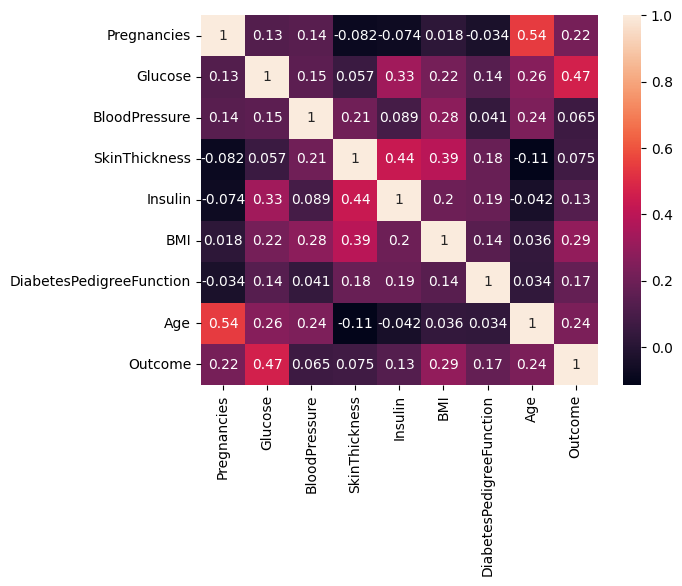

In [18]:
sns.heatmap(df.corr(),annot=True)


<Axes: ylabel='Count'>

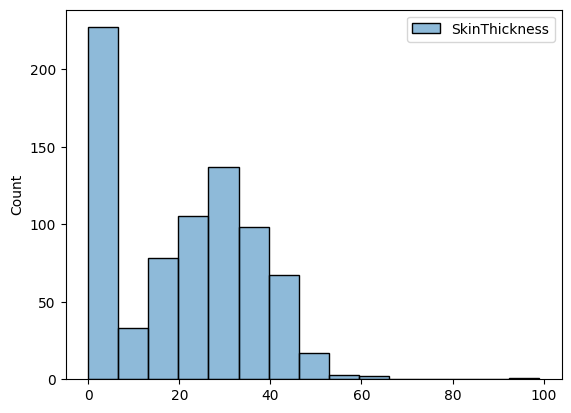

In [19]:
sns.histplot(data=[df['SkinThickness']])

##age, DiabetesPedigreeFunction

<Axes: ylabel='Count'>

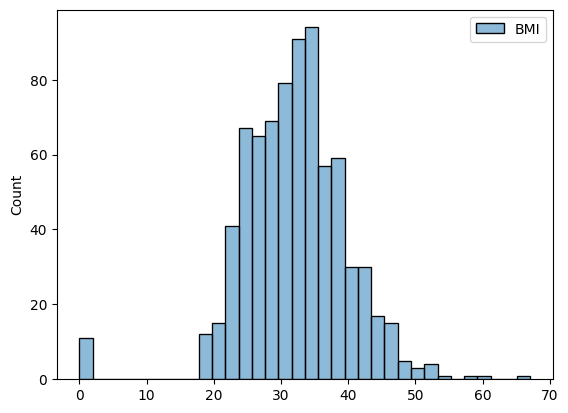

In [20]:
sns.histplot(data=[df['BMI']])


<Axes: ylabel='Count'>

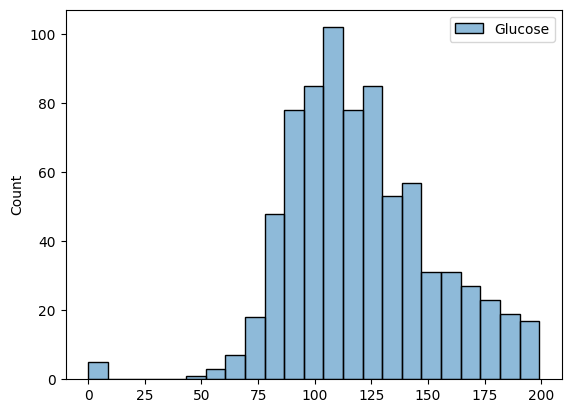

In [21]:
sns.histplot(data=[df['Glucose']])
#age, glucos, BMI

#### Explain the model
1. Data variables
2. Likelihood function and parameters
3. Prior distribution
4. Formal specification
5. Prior predictive check

## 2. Details of the computation



In [19]:
stan_code = """
data {
    // num of observation
    int<lower=0> N;
    // num of success
     vector[N] glucose;
     vector[N] bmi;
}

transformed data {
      vector[N] glucose_std;
      vector[N] bmi_std;
      glucose_std = (glucose - mean(glucose)) / sd(glucose);
      bmi_std = (bmi - mean(bmi)) / sd(bmi);
}


parameters {
  real alpha_std;
  real beta_std;
  real<lower=0> sigma_std;
}


model {
    //prior
    alpha_std ~ normal(0, 5);
    beta_std ~ normal(0, 5);
    sigma_std ~ cauchy(0, 10);
    for (n in 1:N)
    glucose_std[n] ~ normal(alpha_std + beta_std * bmi_std[n],
                      sigma_std);
}

generated quantities {

  real alpha;
  real beta;
  real<lower=0> sigma;
  alpha = sd(bmi) * (alpha_std - beta_std * mean(glucose) / sd(glucose))
           + mean(bmi);
  beta = beta_std * sd(bmi) / sd(glucose);
  sigma = sd(bmi) * sigma_std;

  vector[N] log_lik;
  vector[N] glucose_std_hat;

  for (n in 1:N){
      log_lik[n] = normal_lpdf(glucose_std[n] | alpha_std + beta_std * bmi_std[n], sigma_std);
      glucose_std_hat[n] = normal_rng(glucose_std[n], sigma_std);
  }  
}

"""


### 2-1. Specify data

In [20]:
data = {
"N": len(df), 
"glucose": df.loc[:, "Glucose"].values,
"bmi": df.loc[:, "BMI"].values,
}

### 2-2. Build model

In [21]:
stan_model = stan.build(stan_code, data=data)

Building: found in cache, done.


### 2-3 Fit the model

- quantify with Hamiltonian Monte Carlo


In [22]:
fit = stan_model.sample(num_chains=4, num_samples=1000, num_warmup=500) 
## posterior: Stan generates samples from the joint posterior distribution of the parameters

Sampling:   0%
Sampling:   5% (300/6000)
Sampling:  30% (1800/6000)
Sampling:  55% (3300/6000)
Sampling:  80% (4800/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 0.000556 seconds
  1000 transitions using 10 leapfrog steps per transition would take 5.56 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000226 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.26 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000228 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.28 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000232 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.32 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
 

In [92]:
stan_data_simu = az.from_pystan(
    posterior=fit,
    posterior_predictive="glucose_std_hat",
    log_likelihood={
        "glucose_std": "log_lik",
    },
    observed_data=["glucose"],
    posterior_model=stan_model,
    coords={"glucose_std": np.arange(data["N"])},
)

In [56]:
stan_data_simu

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

[Text(0.5, 1.0, 'Posterior predictive on first data point'),
 Text(0, 0.5, 'Frequency')]

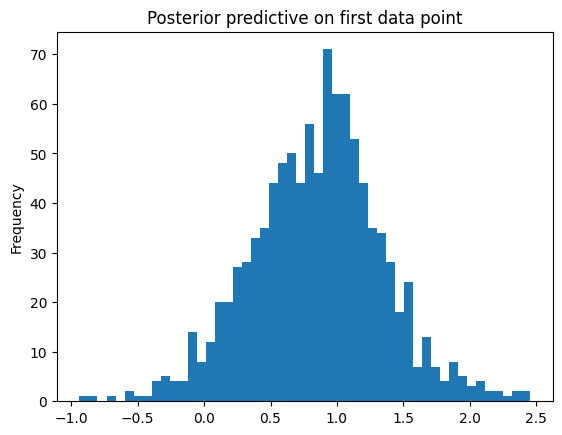

In [70]:
fig, ax = plt.subplots()
ax.hist(stan_data_simu.posterior_predictive.glucose_std_hat.values.mean(axis=0)[:,0], bins=50)
ax.set(title="Posterior predictive on first data point", ylabel="Frequency")

/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (774) in plot_posterior, generating only 40 plots
  warnings.warn(


array([[<Axes: title={'center': 'alpha_std'}>,
        <Axes: title={'center': 'beta_std'}>,
        <Axes: title={'center': 'sigma_std'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'glucose_std_hat\n0'}>,
        <Axes: title={'center': 'glucose_std_hat\n1'}>],
       [<Axes: title={'center': 'glucose_std_hat\n2'}>,
        <Axes: title={'center': 'glucose_std_hat\n3'}>,
        <Axes: title={'center': 'glucose_std_hat\n4'}>,
        <Axes: title={'center': 'glucose_std_hat\n5'}>],
       [<Axes: title={'center': 'glucose_std_hat\n6'}>,
        <Axes: title={'center': 'glucose_std_hat\n7'}>,
        <Axes: title={'center': 'glucose_std_hat\n8'}>,
        <Axes: title={'center': 'glucose_std_hat\n9'}>],
       [<Axes: title={'center': 'glucose_std_hat\n10'}>,
        <Axes: title={'center': 'glucose_std_hat\n11'}>,
        <Axes: title={'center': 'glucose_std_hat\n12'}

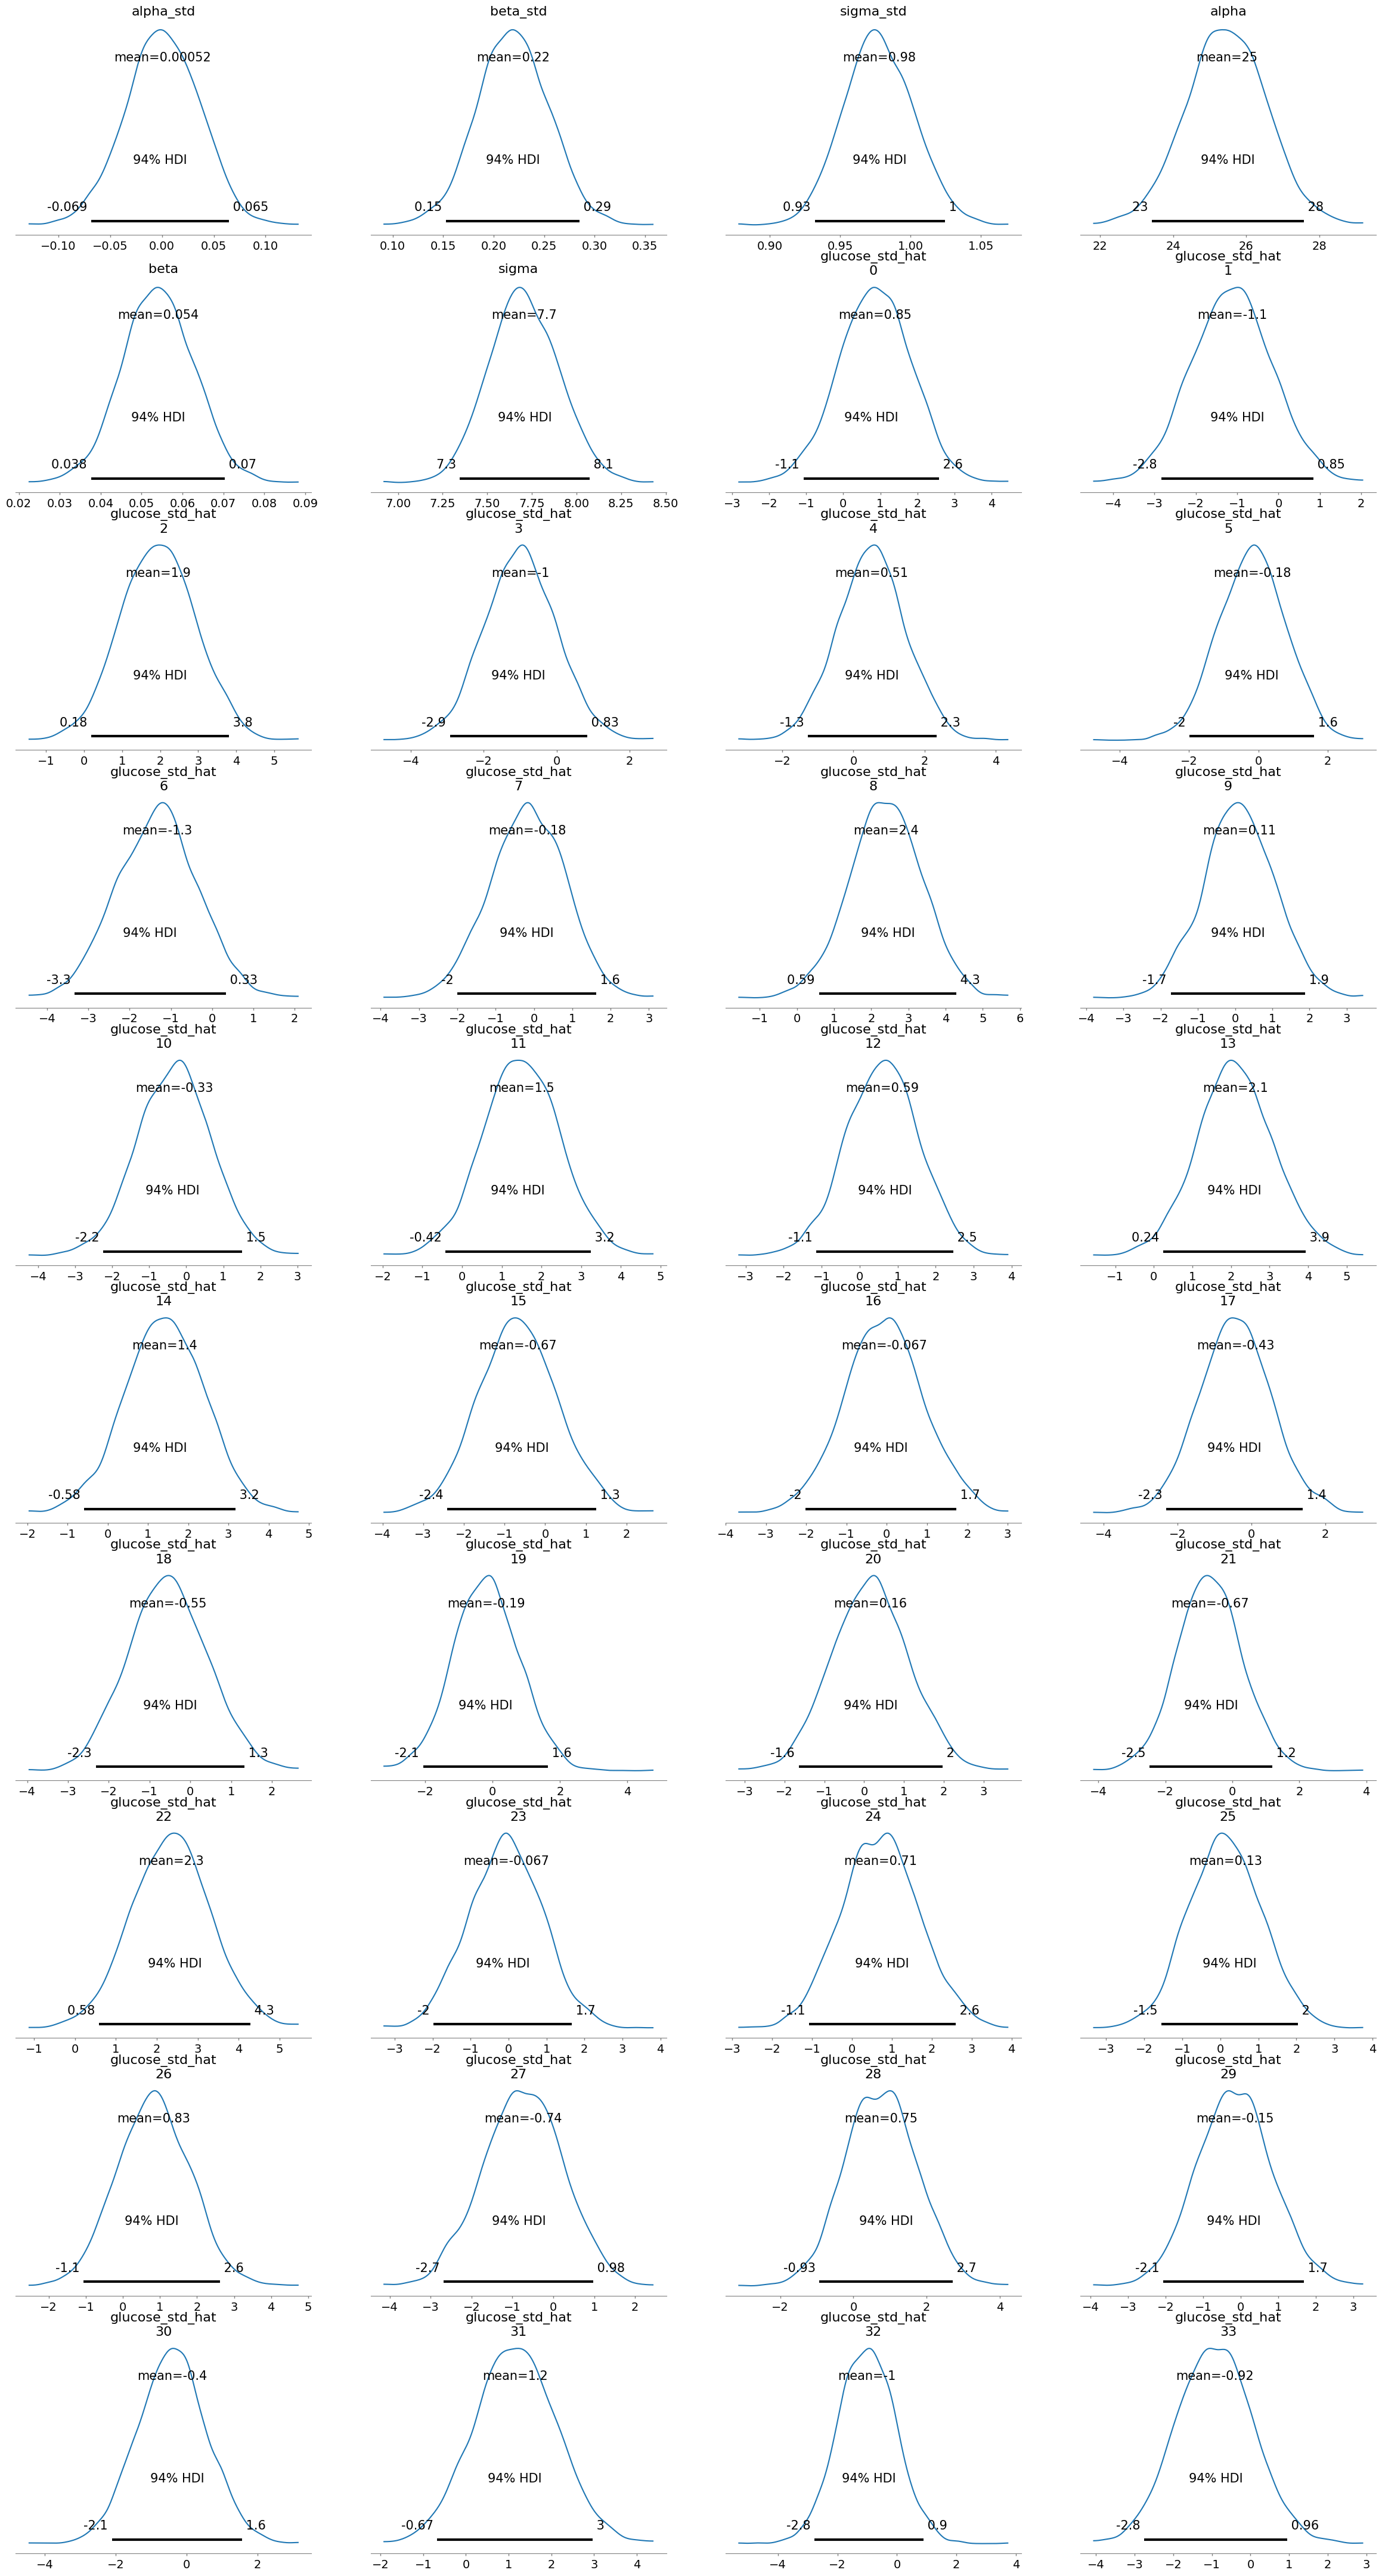

In [73]:
az.plot_posterior(fit)

/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/matplotlib/transforms.py:1770: RuntimeWarning: coroutine 'build.<locals>.go' was never awaited
  super().__init__(*args, **kwargs)


<Axes: xlabel='glucose / glucose_std_hat'>

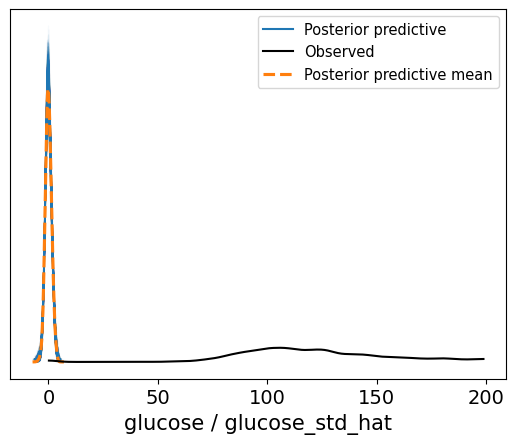

In [31]:
az.plot_ppc(stan_data_simu, data_pairs={"glucose": "glucose_std_hat"}, alpha=0.03, textsize=14)

array([[<Axes: title={'center': 'alpha_std'}>,
        <Axes: title={'center': 'alpha_std'}>],
       [<Axes: title={'center': 'beta_std'}>,
        <Axes: title={'center': 'beta_std'}>],
       [<Axes: title={'center': 'sigma_std'}>,
        <Axes: title={'center': 'sigma_std'}>],
       [<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

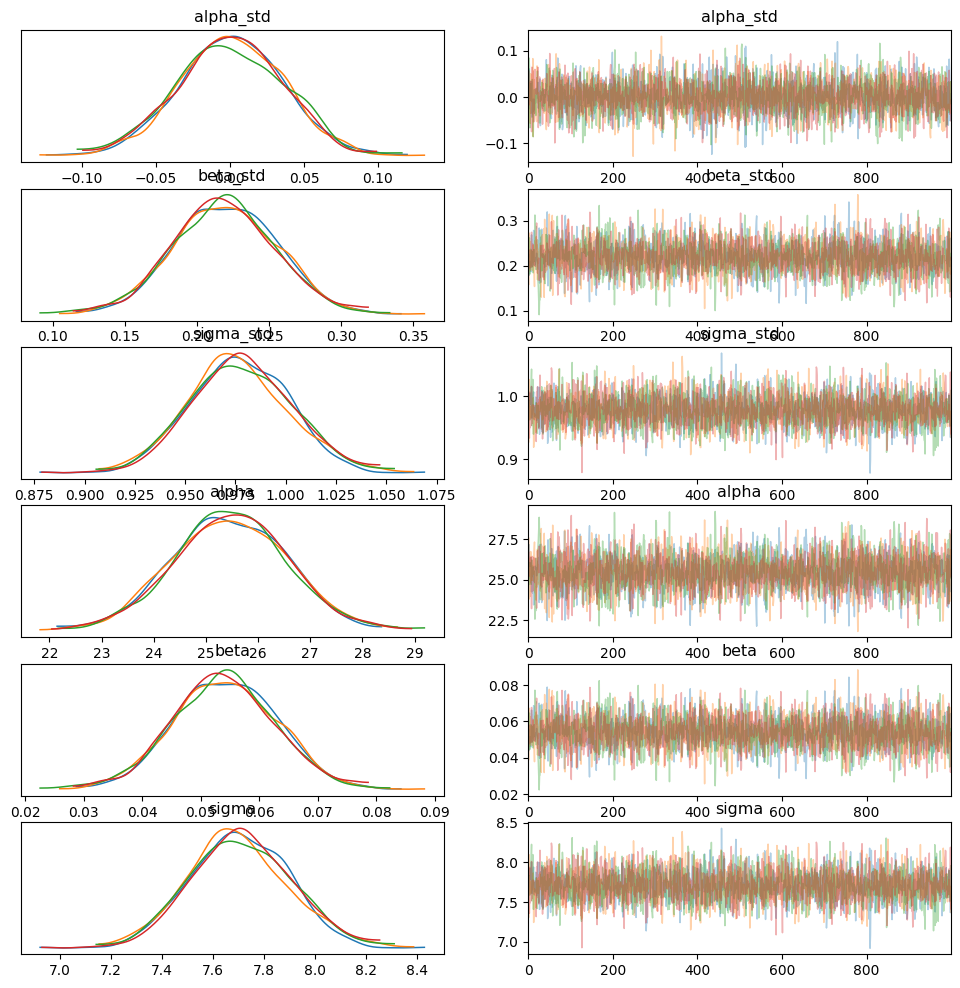

In [72]:
az.plot_trace(stan_data_simu, compact=False)

In [42]:
summary1 = az.summary(fit) #https://python.arviz.org/en/stable/getting_started/Introduction.html

In [43]:
summary1

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha_std,0.001,0.036,-0.069,0.065,0.001,0.001,4995.0,2947.0,1.0
beta_std,0.219,0.036,0.153,0.285,0.001,0.000,3531.0,2836.0,1.0
sigma_std,0.977,0.025,0.932,1.024,0.000,0.000,3781.0,2744.0,1.0
alpha,25.460,1.104,23.419,27.583,0.018,0.013,3589.0,2831.0,1.0
beta,0.054,0.009,0.038,0.070,0.000,0.000,3531.0,2836.0,1.0
...,...,...,...,...,...,...,...,...,...
glucose_std_hat[763],-0.623,0.986,-2.467,1.259,0.016,0.011,3911.0,3803.0,1.0
glucose_std_hat[764],0.038,0.989,-1.874,1.850,0.016,0.011,3822.0,3881.0,1.0
glucose_std_hat[765],-0.013,0.960,-1.849,1.721,0.015,0.011,3937.0,3852.0,1.0
glucose_std_hat[766],0.159,0.973,-1.708,1.931,0.016,0.012,3566.0,3725.0,1.0


In [49]:
fake = {
"N": len(df_simu), 
"glucose": df_simu.loc[:, "Glucose"].values,
"bmi": df_simu.loc[:, "BMI"].values,
}

In [50]:
stan_model_fake = stan.build(stan_code, data=fake)

Building: 0.2s
Building: 0.3s
Building: 0.4s
Building: 0.5s
Building: 0.7s
Building: 0.8s
Building: 0.9s
Building: 1.0s
Building: 1.1s
Building: 1.2s
Building: 1.3s
Building: 1.4s
Building: 1.5s
Building: 1.6s
Building: 1.7s
Building: 1.8s
Building: 1.9s
Building: 2.0s
Building: 2.1s
Building: 2.2s
Building: 2.3s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/3kvydbcx/model_3kvydbcx.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:8:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core.hpp:10:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core/chainable_object.hpp:6:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core/typedefs.hpp:7:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-pac

Building: 2.4s
Building: 2.5s
Building: 2.6s
Building: 2.7s
Building: 2.8s
Building: 2.9s
Building: 3.0s
Building: 3.1s
Building: 3.2s
Building: 3.3s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/3kvydbcx/model_3kvydbcx.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:26:
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/beta.hpp:70:32: warning: lambda capture 'b' is not used [-Wunused-lambda-capture]
                           [a, b, digamma_ab](auto& vi) mutable {
                             ~~^


Building: 3.4s
Building: 3.5s
Building: 3.6s
Building: 3.7s
Building: 3.9s
Building: 4.0s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/3kvydbcx/model_3kvydbcx.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:55:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/

Building: 4.1s
Building: 4.2s
Building: 4.3s
Building: 4.4s
Building: 4.5s
Building: 4.6s
Building: 4.7s
Building: 4.8s
Building: 4.9s
Building: 5.0s
Building: 5.1s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/3kvydbcx/model_3kvydbcx.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:198:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/functor.hpp:12:
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/functor/hcubature.hpp:468:7: warning: unused variable 'kdiv' [-Wunused-variable]
  int kdiv = kdivide;
      ^


Building: 5.2s
Building: 5.3s
Building: 5.4s
Building: 5.5s
Building: 5.6s
Building: 5.7s
Building: 5.8s
Building: 5.9s
Building: 6.0s
Building: 6.1s
Building: 6.2s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/3kvydbcx/model_3kvydbcx.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:198:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/functor.hpp:15:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/functor/integrate_ode_rk45.hpp:6:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-

Building: 6.3s
Building: 6.4s
Building: 6.5s
Building: 6.6s
Building: 6.7s
Building: 6.8s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/3kvydbcx/model_3kvydbcx.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:14:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim.hpp:16:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob.hpp:128:
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob/gaussian_dlm_obs_rng.hpp:98:7: warning: unused variable 'n' [-Wunused-variable]
  int n = G.rows();  // number of states
      ^


Building: 6.9s
Building: 7.0s
Building: 7.1s
Building: 7.3s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/3kvydbcx/model_3kvydbcx.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:14:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim.hpp:16:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob.hpp:210:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob/multi_student_t_log.hpp:5:
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan

Building: 7.4s
Building: 7.5s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/3kvydbcx/model_3kvydbcx.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:14:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim.hpp:16:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob.hpp:312:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob/skew_double_exponential_ccdf_log.hpp:5:
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan

Building: 7.6s
Building: 7.7s
Building: 7.8s


/Users/eunkang/Library/Caches/httpstan/4.10.1/models/3kvydbcx/model_3kvydbcx.cpp:333:11: warning: variable 'pos__' set but not used [-Wunused-but-set-variable]
      int pos__ = std::numeric_limits<int>::min();
          ^
/Users/eunkang/Library/Caches/httpstan/4.10.1/models/3kvydbcx/model_3kvydbcx.cpp:371:11: warning: variable 'pos__' set but not used [-Wunused-but-set-variable]
      int pos__ = std::numeric_limits<int>::min();
          ^


Building: 7.9s
Building: 8.0s
Building: 8.1s
Building: 8.2s
Building: 8.3s
Building: 8.4s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/3kvydbcx/model_3kvydbcx.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:55:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/

Building: 8.5s
Building: 8.6s
Building: 8.7s
Building: 8.8s
Building: 8.9s


/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp:192:12: warning: unused variable 'pre_mult' [-Wunused-variable]
      auto pre_mult = a2 * pow(1 - z, -1 - a2);
           ^
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp:307:20: note: in instantiation of function template specialization 'stan::math::internal::grad_2F1_impl<true, true, true, true, stan::math::var_value<double>, stan::math::var_value<double>, stan::math::var_value<double>, stan::math::var_value<double>, stan::math::var_value<double>, std::tuple<stan::math::var_value<double>, stan::math::var_value<double>, stan::math::var_value<double>, stan::math::var_value<double>>>' requested here
  return internal::grad_2F1_impl<true, true, true, true>(a1, a2, b1, z,
                   ^
In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/3kvydbcx/model_3kvydbcx.cpp:2:
In file i

Building: 9.0s
Building: 9.1s
Building: 9.2s
Building: 9.3s
Building: 9.4s
Building: 9.5s
Building: 9.6s
Building: 9.7s
Building: 9.8s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/3kvydbcx/model_3kvydbcx.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:100:
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/lb_constrain.hpp:114:33: warning: lambda capture 'lp' is not used [-Wunused-lambda-capture]
                               [lp, arena_lb = var(lb)](auto& vi) mutable {
                                ^
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/h

Building: 9.9s
Building: 10.0s
Building: 10.1s
Building: 10.2s
Building: 10.3s
Building: 10.4s
Building: 10.5s
Building: 10.6s
Building: 10.8s
Building: 10.9s
Building: 11.0s
Building: 11.1s
Building: 11.2s
Building: 11.3s
Building: 11.4s
Building: 11.5s
Building: 11.6s
Building: 11.7s
Building: 11.8s
Building: 11.9s
Building: 12.0s
Building: 12.1s
Building: 12.2s
Building: 12.3s
Building: 12.4s
Building: 12.5s
Building: 12.6s
Building: 12.7s
Building: 12.8s
Building: 12.9s
Building: 13.0s
Building: 13.1s
Building: 13.2s
Building: 13.3s


21 warnings generated.
ld: warning: object file (/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/stan_services.o) was built for newer macOS version (11.0) than being linked (10.9)
ld: warning: dylib (/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/lib/libtbbmalloc.dylib) was built for newer macOS version (10.11) than being linked (10.9)
ld: warning: dylib (/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/lib/libtbbmalloc_proxy.dylib) was built for newer macOS version (10.11) than being linked (10.9)
ld: warning: dylib (/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/lib/libtbb.dylib) was built for newer macOS version (10.11) than being linked (10.9)
ld: warning: object file (/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/lib/libsundials_nvecserial.a(nvector_serial.o)) was built for newer macOS version (11.0) than being linked (10.9)
ld: warning: ob

In [51]:
fit_fake = stan_model_fake.sample(num_chains=4, num_samples=1000, num_warmup=500) 
## posterior: Stan generates samples from the joint posterior distribution of the parameters

Sampling:   0%
Sampling:   0% (1/6000)
Sampling:   2% (101/6000)
Sampling:   3% (201/6000)
Sampling:   5% (301/6000)
Sampling:   8% (500/6000)
Sampling:  10% (600/6000)
Sampling:  12% (700/6000)
Sampling:  15% (900/6000)
Sampling:  18% (1100/6000)
Sampling:  22% (1300/6000)
Sampling:  43% (2600/6000)
Sampling:  63% (3800/6000)
Sampling:  82% (4900/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 0.000782 seconds
  1000 transitions using 10 leapfrog steps per transition would take 7.82 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.00075 seconds
  1000 transitions using 10 leapfrog steps per transition would take 7.5 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000753 seconds
  1000 transitions using 10 leapfrog steps per transition would take 7.53 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000814 seconds
  100

In [53]:
stan_data_simu_fake = az.from_pystan(
    posterior=fit_fake,
    posterior_predictive="glucose_std_hat",
    log_likelihood={
        "glucose_std": "log_lik",
    },
    observed_data=["glucose"],
    posterior_model=stan_model_fake,
    coords={"glucose_std": np.arange(fake["N"])},
)

<Axes: xlabel='glucose / glucose_std_hat'>

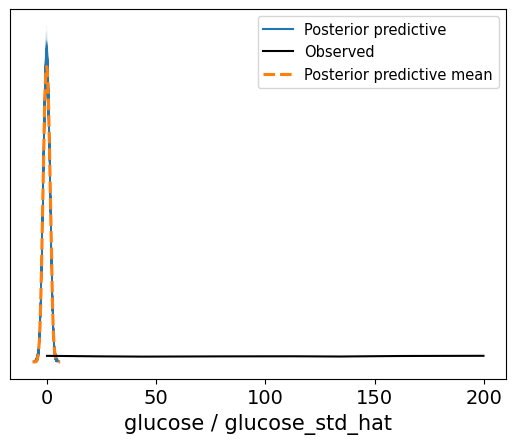

In [57]:
az.plot_ppc(stan_data_simu_fake, data_pairs={"glucose": "glucose_std_hat"}, alpha=0.03, textsize=14)

In [64]:
summary_fake = az.summary(fit_fake) #https://python.arviz.org/en/stable/getting_started/Introduction.html

In [66]:
summary_fake

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha_std,-0.000,0.018,-0.035,0.033,0.000,0.000,3943.0,2992.0,1.0
beta_std,0.003,0.018,-0.033,0.036,0.000,0.000,3099.0,2706.0,1.0
sigma_std,1.001,0.013,0.976,1.025,0.000,0.000,4933.0,3419.0,1.0
alpha,33.256,0.699,31.963,34.588,0.012,0.009,3371.0,2812.0,1.0
beta,0.001,0.006,-0.011,0.012,0.000,0.000,3099.0,2706.0,1.0
...,...,...,...,...,...,...,...,...,...
glucose_std_hat[2995],0.169,1.016,-1.576,2.207,0.016,0.012,3877.0,3878.0,1.0
glucose_std_hat[2996],-0.735,0.988,-2.590,1.118,0.016,0.011,4041.0,3707.0,1.0
glucose_std_hat[2997],0.553,1.024,-1.305,2.531,0.016,0.011,4020.0,3799.0,1.0
glucose_std_hat[2998],0.205,1.000,-1.554,2.181,0.016,0.011,4029.0,3689.0,1.0


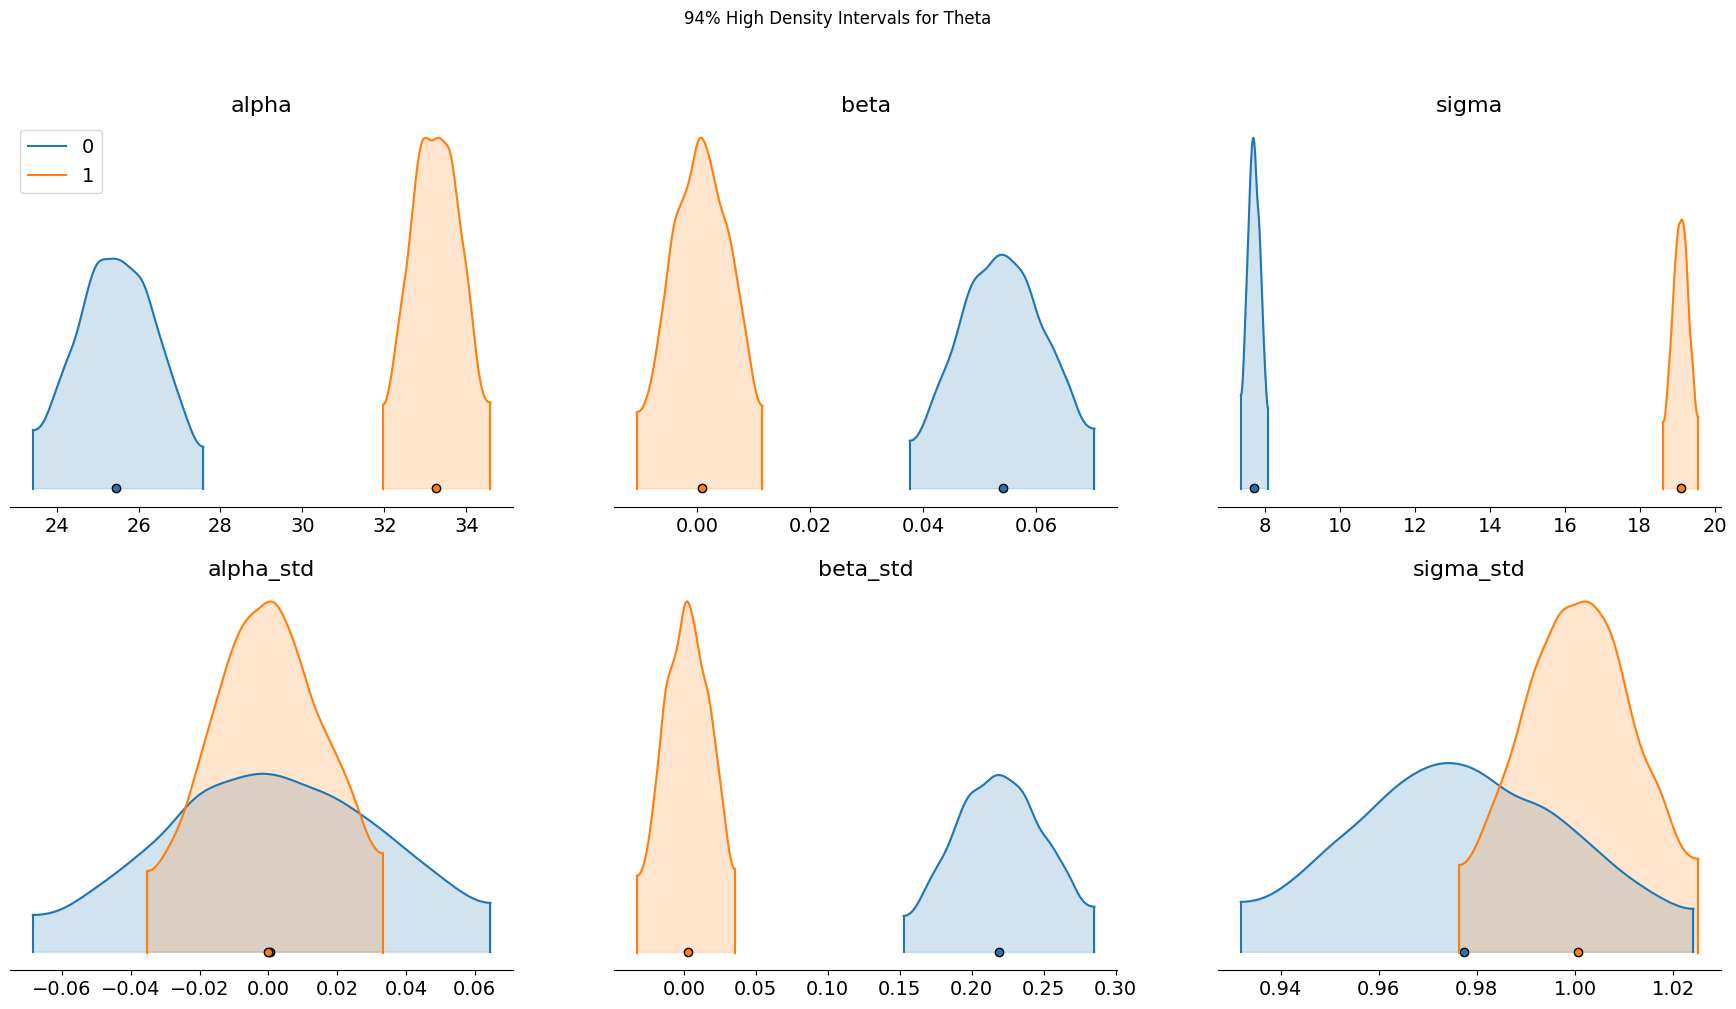

In [62]:
## compare two plots 

axes = az.plot_density(
    [stan_data_simu, stan_data_simu_fake],
    group="posterior",
    var_names=["alpha", "beta", "sigma", "alpha_std", "beta_std", "sigma_std"],
    shade=0.2,
)

fig = axes.flatten()[0].get_figure()
fig.suptitle("94% High Density Intervals for Theta")

plt.show()

In [53]:
stan_code_post = """
data {
    // num of observation
    int<lower=0> N;
    // num of success
     vector[N] glucose;
     vector[N] diabetes;
     vector[N] bmi;

}

parameters {
    //prob of success
    real alpha;
    real beta;
    real beta2;

    real<lower=0> sigma;
}

transformed parameters {
     real<lower=0> alpha_inv;
      alpha_inv = 1 / alpha;
}

model {
    //prior
    // alpha ~ normal(0, 1);
    beta ~ normal(0, 1);
    beta2 ~ normal(0,1);
    sigma ~ cauchy(0, 1);
    diabetes ~ gamma(alpha_inv + beta * glucose + beta2 * bmi, sigma); //likelihood
}

generated quantities {
    vector[N] log_lik;
    vector[N] diabetes_pred;

    //log-likelihood
    for (n in 1:N){
     log_lik[n] = gamma_lpdf(diabetes[n] | alpha_inv + beta * glucose[n] + beta2 * bmi[n], sigma);
    }
    
    //predictive 
     for (n in 1:N) {
        diabetes_pred[n] = gamma_rng(alpha_inv + beta * glucose[n] + beta2 * bmi[n], sigma);
    }
}

"""


In [54]:
data_post = {
"N": len(df), 
"glucose": df.loc[:, "Glucose"].values,
"diabetes": stan_data_simu.observed_data.diabetes.values,
"bmi": df.loc[:, "BMI"].values,
}

In [55]:
stan_model_post = stan.build(stan_code_post, data=data_post)

Building: 0.2s
Building: 0.3s
Building: 0.4s
Building: 0.5s
Building: 0.6s
Building: 0.7s
Building: 0.8s
Building: 0.9s
Building: 1.0s
Building: 1.1s
Building: 1.2s
Building: 1.3s
Building: 1.5s
Building: 1.6s
Building: 1.7s
Building: 1.8s
Building: 1.9s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/rkp75vbj/model_rkp75vbj.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:8:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core.hpp:10:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core/chainable_object.hpp:6:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core/typedefs.hpp:7:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-pac

Building: 2.0s
Building: 2.1s
Building: 2.2s
Building: 2.3s
Building: 2.4s
Building: 2.5s
Building: 2.6s
Building: 2.7s
Building: 2.8s
Building: 2.9s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/rkp75vbj/model_rkp75vbj.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:26:
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/beta.hpp:70:32: warning: lambda capture 'b' is not used [-Wunused-lambda-capture]
                           [a, b, digamma_ab](auto& vi) mutable {
                             ~~^


Building: 3.0s
Building: 3.1s
Building: 3.2s
Building: 3.3s
Building: 3.4s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/rkp75vbj/model_rkp75vbj.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:55:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/

Building: 3.5s
Building: 3.6s
Building: 3.7s
Building: 3.8s
Building: 3.9s
Building: 4.0s
Building: 4.1s
Building: 4.2s
Building: 4.3s
Building: 4.4s
Building: 4.5s
Building: 4.6s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/rkp75vbj/model_rkp75vbj.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:198:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/functor.hpp:12:
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/functor/hcubature.hpp:468:7: warning: unused variable 'kdiv' [-Wunused-variable]
  int kdiv = kdivide;
      ^


Building: 4.7s
Building: 4.8s
Building: 5.0s
Building: 5.1s
Building: 5.2s
Building: 5.3s
Building: 5.4s
Building: 5.5s
Building: 5.6s
Building: 5.7s
Building: 5.8s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/rkp75vbj/model_rkp75vbj.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:198:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/functor.hpp:15:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/functor/integrate_ode_rk45.hpp:6:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-

Building: 5.9s
Building: 6.0s
Building: 6.1s
Building: 6.2s
Building: 6.3s
Building: 6.4s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/rkp75vbj/model_rkp75vbj.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:14:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim.hpp:16:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob.hpp:128:
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob/gaussian_dlm_obs_rng.hpp:98:7: warning: unused variable 'n' [-Wunused-variable]
  int n = G.rows();  // number of states
      ^


Building: 6.5s
Building: 6.6s
Building: 6.7s
Building: 6.8s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/rkp75vbj/model_rkp75vbj.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:14:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim.hpp:16:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob.hpp:210:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob/multi_student_t_log.hpp:5:
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan

Building: 6.9s
Building: 7.0s
Building: 7.1s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/rkp75vbj/model_rkp75vbj.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:14:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim.hpp:16:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob.hpp:312:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob/skew_double_exponential_ccdf_log.hpp:5:
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan

Building: 7.2s
Building: 7.3s


/Users/eunkang/Library/Caches/httpstan/4.10.1/models/rkp75vbj/model_rkp75vbj.cpp:334:11: warning: variable 'pos__' set but not used [-Wunused-but-set-variable]
      int pos__ = std::numeric_limits<int>::min();
          ^
/Users/eunkang/Library/Caches/httpstan/4.10.1/models/rkp75vbj/model_rkp75vbj.cpp:379:11: warning: variable 'pos__' set but not used [-Wunused-but-set-variable]
      int pos__ = std::numeric_limits<int>::min();
          ^


Building: 7.4s
Building: 7.5s
Building: 7.6s
Building: 7.7s
Building: 7.8s
Building: 7.9s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/rkp75vbj/model_rkp75vbj.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:55:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/

Building: 8.0s
Building: 8.1s
Building: 8.2s
Building: 8.3s
Building: 8.5s


/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp:192:12: warning: unused variable 'pre_mult' [-Wunused-variable]
      auto pre_mult = a2 * pow(1 - z, -1 - a2);
           ^
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp:307:20: note: in instantiation of function template specialization 'stan::math::internal::grad_2F1_impl<true, true, true, true, stan::math::var_value<double>, stan::math::var_value<double>, stan::math::var_value<double>, stan::math::var_value<double>, stan::math::var_value<double>, std::tuple<stan::math::var_value<double>, stan::math::var_value<double>, stan::math::var_value<double>, stan::math::var_value<double>>>' requested here
  return internal::grad_2F1_impl<true, true, true, true>(a1, a2, b1, z,
                   ^
In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/rkp75vbj/model_rkp75vbj.cpp:2:
In file i

Building: 8.6s
Building: 8.7s
Building: 8.8s
Building: 8.9s
Building: 9.0s
Building: 9.1s
Building: 9.2s
Building: 9.3s
Building: 9.4s
Building: 9.5s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/rkp75vbj/model_rkp75vbj.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:100:
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/lb_constrain.hpp:114:33: warning: lambda capture 'lp' is not used [-Wunused-lambda-capture]
                               [lp, arena_lb = var(lb)](auto& vi) mutable {
                                ^
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/h

Building: 9.6s
Building: 9.7s
Building: 9.8s
Building: 9.9s
Building: 10.0s
Building: 10.1s
Building: 10.2s
Building: 10.3s
Building: 10.4s
Building: 10.5s
Building: 10.6s
Building: 10.7s
Building: 10.8s
Building: 10.9s
Building: 11.0s
Building: 11.1s
Building: 11.2s
Building: 11.3s
Building: 11.4s
Building: 11.5s
Building: 11.6s
Building: 11.7s
Building: 11.8s
Building: 11.9s
Building: 12.0s
Building: 12.2s
Building: 12.3s
Building: 12.4s
Building: 12.5s
Building: 12.6s
Building: 12.7s
Building: 12.8s
Building: 12.9s
Building: 13.0s
Building: 13.1s
Building: 13.2s
Building: 13.3s
Building: 13.4s
Building: 13.5s
Building: 13.6s


21 warnings generated.
ld: warning: object file (/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/stan_services.o) was built for newer macOS version (11.0) than being linked (10.9)
ld: warning: dylib (/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/lib/libtbbmalloc.dylib) was built for newer macOS version (10.11) than being linked (10.9)
ld: warning: dylib (/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/lib/libtbb.dylib) was built for newer macOS version (10.11) than being linked (10.9)
ld: warning: dylib (/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/lib/libtbbmalloc_proxy.dylib) was built for newer macOS version (10.11) than being linked (10.9)
ld: warning: object file (/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/lib/libsundials_nvecserial.a(nvector_serial.o)) was built for newer macOS version (11.0) than being linked (10.9)
ld: warning: ob

In [ ]:
fit2 = stan_model_post.sample(num_chains=4, num_samples=1000) 
## posterior: Stan generates samples from the joint posterior distribution of the parameters

Sampling:   0%
Sampling:   4% (300/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  19% (1500/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  26% (2100/8000)
Sampling:  30% (2400/8000)
Sampling:  31% (2500/8000)
Sampling:  34% (2700/8000)
Sampling:  44% (3500/8000)
Sampling:  46% (3700/8000)
Sampling:  48% (3800/8000)
Sampling:  49% (3900/8000)
Sampling:  58% (4600/8000)
Sampling:  59% (4701/8000)
Sampling:  60% (4801/8000)
Sampling:  61% (4901/8000)
Sampling:  63% (5001/8000)
Sampling:  64% (5101/8000)
Sampling:  65% (5200/8000)
Sampling:  66% (5300/8000)
Sampling:  68% (5400/8000)
Sampling:  69% (5500/8000)
Sampling:  70% (5600/8000)
Sampling:  71% (5700/8000)
Sampling:  73% (5801/8000)
Sampling:  74% (5900/8000)
Sampling:  75% (6000

## 3. Validate a fit. Diagnostics

The visualization shows that the simulated data sets (diabetes_rep) are different from observed log.

In [ ]:
## diagnostic test with treedepth 

def check_treedepth(summary, max_treedepth = 10, quiet=False):
    """Check transitions that ended prematurely due to maximum tree depth limit"""
    # sampler_params = fit.get_sampler_params(inc_warmup=False)
    sampler_params = summary.sample_stats['tree_depth'].values
    depths = [x for y in sampler_params for x in y]
    n = sum(1 for x in depths if x == max_treedepth)
    N = len(depths)

    if not quiet:
        print(('{} of {} iterations saturated the maximum tree depth of {}'
              + ' ({}%)').format(n, N, max_treedepth, 100 * n / N))
    if n > 0:
        if not quiet:
            print('  Run again with max_treedepth set to a larger value to avoid saturation')
        else:
            return False
    else:
        if quiet:
            return True

In [ ]:
## diagnostic test with divergence

def check_div(summary, quiet=False):
    """Check transitions that ended with a divergence"""
    sampler_params = summary.sample_stats['diverging'].values
    divergent = [x for y in sampler_params for x in y]
    # n = sum(divergent)
    divergent = [True if element == "True" else False for element in divergent]
    n = divergent.count(True)
    N = len(divergent)
    if not quiet:
        print('{} of {} iterations ended with a divergence ({}%)'.format(n, N,
            100 * n / N))

    if n > 0:
        if not quiet:
            print('  Try running with larger adapt_delta to remove the divergences')
        else:
            return False
    else:
        if quiet:
            return True

## 0. delete cache of model

In [34]:
# import the relevant modules
import shutil
import httpstan.models
import httpstan.cache

In [35]:
httpstan.cache.list_model_names()

['models/4jtk6kyf',
 'models/dtgn375g',
 'models/pg5d6qre',
 'models/vtkvn3y7',
 'models/3kvydbcx',
 'models/cyxyefnp']

In [41]:
httpstan.cache.delete_model_directory('models/cyxyefnp') ## add the model pointer you want to remove

## 0. Saving model (not done)

In [24]:

def save(obj, filename):
    """Save compiled models for reuse."""
    import pickle
    with open(filename, 'wb') as f:
        pickle.dump(obj, f, protocol=pickle.HIGHEST_PROTOCOL)

def load(filename):
    """Reload compiled models for reuse."""
    import pickle
    return pickle.load(open(filename, 'rb'))

In [25]:
# save(model, 'norm_model.pic')
# new_model = load('norm_model.pic')


In [188]:
import pickle

In [26]:
# with open("model_fit.pkl", "rb") as f:
#     data_dict = pickle.load(f)
#     # or with a list
#     # data_list = pickle.load(f)
# fit_new = data_dict['fit']
# # fit = data_list[1]

In [ ]:
# with open("model_fit.pkl", "wb") as f:
#     pickle.dump({'model' : stan_model, 'fit' : fit}, f, protocol=-1)
#     # or with a list
#     # pickle.dump([model, fit], f, protocol=-1)